In [161]:
#%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d   
import numpy as np
import sys
import pandas as pd
from numpy import exp, loadtxt, pi, sqrt
from mpl_toolkits import mplot3d
import seaborn as sns
import math
np.set_printoptions(threshold=sys.maxsize)
# To solve for cross-section limit
from scipy.optimize import brentq

In [162]:
CosSunRecoAndTrue = np.loadtxt('CosSunRecoAndTrue.dat')
CosSunTotalMomentumReco = np.loadtxt('CosSunTotalMomentumReco.dat')

In [163]:
Recob10 = CosSunRecoAndTrue[0:7898,0].astype(np.float)
Trueb10 = CosSunRecoAndTrue[0:7898,1].astype(np.float)
Recob1p5 = CosSunRecoAndTrue[7898:13742,0].astype(np.float) 
Trueb1p5 = CosSunRecoAndTrue[7898:13742,1].astype(np.float) 
Recob1p1 = CosSunRecoAndTrue[13743:14542,0].astype(np.float)  
Trueb1p1 = CosSunRecoAndTrue[13743:14542,1].astype(np.float)  

BackGround = CosSunTotalMomentumReco.astype(np.float)

# backgroundScale = number of NC events for 10 kt .y (From Josh Barrow thesis) at ...
#... truth level x 4 times fiducial volume x 10 years x Reconstructed and True Information Ratio 
#... divided by the total number of NC events analyzed

backgroundScale = 909* 4 * 10 *  0.31/11853


def optimizeSelection( Reco, gamma, BG):

    nSignalTotal = 10000 #Total number of events analyzed for each gamma sample
    nBGTotal = 0
    SprimeMin = 0
    bestCut = 0
    bestEff = 0
    bestBkg = 0
    bestBkgErr = 0

    CosCuts = np.linspace(0,0.95,30)
   
    nBGTotal = len(BG)

    rReco = 0
    bEvents = 0
    SprimeMin = 10000000.
    for CosCut in CosCuts:
        nReco = 0
        nBG = 0
        for Cos in Reco:
            if CosCut < Cos:
                nReco+=1
        for Cos in BG:
            if CosCut < Cos:
                nBG+=1
        rReco = nReco/nSignalTotal  
        bEvents = nBG*backgroundScale

        Sprime = 25./ (2.*rReco) + math.sqrt( 25.*bEvents/ (rReco*rReco) + 625./(4.*rReco*rReco) )
   
        if Sprime < SprimeMin:
            SprimeMin = Sprime
            bestCut = CosCut
            bestEff = rReco
            bestBkg = bEvents
            bestBkgErr = math.sqrt( nBG )*backgroundScale/11853
            #print (bestCut, bestEff, bestBkg, bestBkgErr)
    return bestCut, bestEff, bestBkg, bestBkgErr

eff = []
Bkg = []
BCut = []
BkgErr = []
gamma=1.1
bestCut, bestEff, bestBkg, bestBkgErr = optimizeSelection(Recob1p1, gamma, BackGround)
print( 'gamma %d: optimal cut at %f, signal efficieny = %f, background counts = %f, background uncertainty =  %f\n' %( gamma, bestCut, bestEff, bestBkg, bestBkgErr ) )
eff.append(bestEff)
Bkg.append(bestBkg)
BCut.append(bestCut)
BkgErr.append(bestBkgErr)
gamma=1.5
bestCut, bestEff, bestBkg, bestBkgErr= optimizeSelection(Recob1p5, gamma, BackGround)
print( 'gamma %d: optimal cut at %f, signal efficieny = %f, background counts = %f, background uncertainty =  %f\n' %( gamma, bestCut, bestEff, bestBkg, bestBkgErr ) )
eff.append(bestEff)
Bkg.append(bestBkg)
BCut.append(bestCut)
BkgErr.append(bestBkgErr)
gamma=10
bestCut, bestEff, bestBkg, bestBkgErr = optimizeSelection(Recob10, gamma, BackGround)
print( 'gamma %d: optimal cut at %f, signal efficieny = %f, background counts = %f, background uncertainty =  %f\n' %( gamma, bestCut, bestEff, bestBkg, bestBkgErr ) )
eff.append(bestEff)
Bkg.append(bestBkg)
BCut.append(bestCut)
BkgErr.append(bestBkgErr)

gamma 1: optimal cut at 0.360345, signal efficieny = 0.060200, background counts = 1124.972817, background uncertainty =  0.002759

gamma 1: optimal cut at 0.294828, signal efficieny = 0.381300, background counts = 1238.135763, background uncertainty =  0.002895

gamma 10: optimal cut at 0.589655, signal efficieny = 0.514900, background counts = 701.800456, background uncertainty =  0.002180



In [164]:

########################################################################################
# Calculate the sensitivity/expected sensitivity
########################################################################################

# Number of target Argon nuclei and livetime of DUNE
NA_dune = 4 * 1.5e32             # 40 kton
livetime_dune = 10.0 * 3.154e7   # 10 years

sigma2 = 2**2 # 2 sigma -> 95% C.L.

# 1st column is g_Z', should always be 1 in evt. generation
# lighter DM mass
MB = 10
# gamma
gam = np.array([1.1, 1.5, 10])
# Heavy DM mass = Lighter DM mass * gamma
MA = gam * MB
#Flux and BDM-Ar are obtained from the phemenological paper, https://arxiv.org/pdf/1912.05558.pdf
#  flux
flux = np.array([303.6, 203.4, 7521])
#  argon cross section
sigAr = np.array([1.063 * 1e-30, 5.609 * 1e-29, 1.377 * 1e-27])

###############################################################
#     RECONSTRUCTED --- EFFICIENCY AND BACKGROUND EVENTS      #
###############################################################


#  DUNE efficiency - Reconstructed
effDUNE = eff
# expected bkg events after cuts at DUNE - Reconstructed
bkgDUNE = Bkg

evtsDUNE = NA_dune * livetime_dune * flux * sigAr * effDUNE



# Approximate 2 sigma sensitivity
# The square of the significance of an excess neglecting systematics, at large statistics
# minus the squared signfiicance we want: want to find this to be 0
evtsLimDUNE = []

def sigmasq(s):
        return 2.0 * ((s + bkgDUNE[i]) * np.log(1.0 + s / bkgDUNE[i]) - s) - sigma2
for i in range(len(gam)):
    #print(i)
    
    evtsLimDUNE.append(brentq(sigmasq, np.sqrt(bkgDUNE[i])/10.0, np.sqrt(bkgDUNE[i] * 10.0)))
    #evtsLimDUNE_paper.append(brentq(sigmasq, np.sqrt(bkgDUNE_paper[i]), np.sqrt(bkgDUNE_paper[i] * 10.0)))

DLv = np.sqrt(evtsLimDUNE / evtsDUNE)

###############################################################
###############################################################







<IPython.core.display.Javascript object>


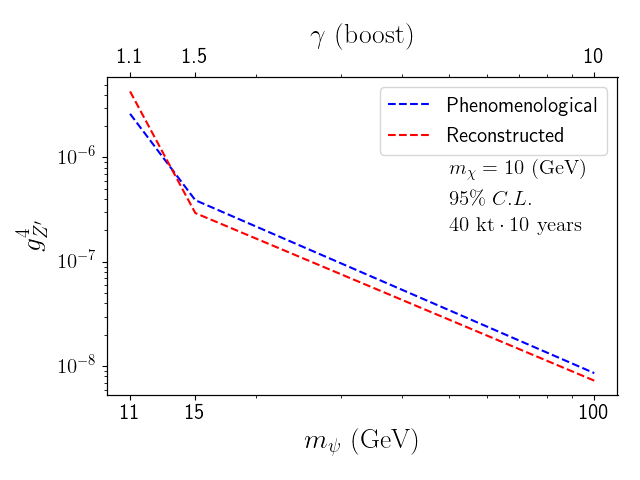

In [165]:
###############################################################
#     PAPER --- EFFICIENCY AND BACKGROUND EVENTS              #
###############################################################

# Nbr. of expected events in nu experiments at g_Z' = 1:
# Number of target nuclei * livetime * flux * cross-section on Argon * efficiency

#  DUNE efficiency
effDUNE_paper = np.array([0.4788, 0.6660, 0.7673])
 # expected bkg events after cuts at DUNE
bkgDUNE_paper = np.array([10006, 11894, 3075])

evtsDUNE_paper = NA_dune * livetime_dune * flux * sigAr * effDUNE_paper

###############################################################
###############################################################


# Redefining variables for the Paper. Data from Table III, https://arxiv.org/pdf/1912.05558.pdf

evtsLimDUNE = []
for i in range(len(gam)):
    def sigmasq(s):
        return 2.0 * ((s + bkgDUNE_paper[i]) * np.log(1.0 + s / bkgDUNE_paper[i]) - s) - sigma2
        # Solve for the number of signal events required for sensitivity
        # We need to give a search range: take sqrt(N_b)/10 to sqrt(N_b) * 10
        # For any "reasonable" number of background events this should be enough

    evtsLimDUNE.append(brentq(sigmasq, np.sqrt(
        bkgDUNE_paper[i])/10.0, np.sqrt(bkgDUNE_paper[i] * 10.0)))

PaperDLv = np.sqrt(evtsLimDUNE / evtsDUNE_paper)

################################################################
#                         PLOT FIGURE                          #
################################################################

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

#ax1.rc('text', usetex=True)
plt.rc('font', size=15)

ax1.plot(MA, PaperDLv, '--',
        label='Phenomenological', color='blue')
ax1.plot(MA, DLv, '--',label='Reconstructed', color='red')
ax2.plot(gam, DLv) 
ax2.cla()


ax1.text(50,0.65e-06,r'$m_\chi=10~(\textrm{GeV})$')
ax1.text(50,0.35e-06,r'$95\%\;C.L.$')
ax1.text(50,0.2e-06,r'$40~\textrm{kt}\cdot 10~\textrm{years}$')
#plt.text(50,1.2e-06,r'$95%\;C.L.$')

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xticks([1.1e1,1.5e1,1e2])
ax1.set_xticklabels(['11','15','100'])
#ax1.set_axis(xlim=[1e0,1.5e2],ylim=[1e-9,1e-4])
ax1.set_xlabel(r'$m_\psi~(\textrm{GeV})$', fontsize=20)
ax1.set_ylabel(r'$g_{Z^\prime}^4$',fontsize=20)
minx,maxx = ax1.get_xlim()
ax2.set_xlim(minx/MB,maxx/MB)
ax2.set_xscale('log')
ax2.set_xticks([1.1e0,1.5e0,1e1])
ax2.set_xticklabels(['1.1','1.5','10'])
ax2.set_xlabel(r'$\gamma~(\textrm{boost})$', fontsize = 20)

ax1.legend()
plt.tight_layout()
plt.show()

############################################################
############################################################


<IPython.core.display.Javascript object>


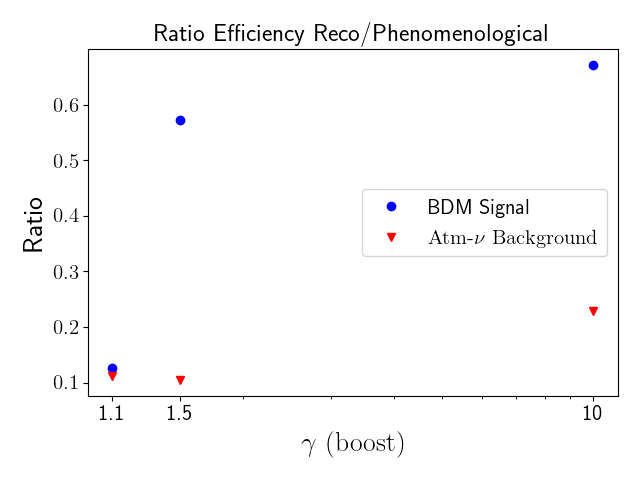

In [166]:
################################################################
#       COMPARE EFFICIENCY - PAPER AND RECO                    #
################################################################

plt.figure()
plt.title('Ratio Efficiency Reco/Phenomenological')
plt.plot(gam,effDUNE/effDUNE_paper,'o', color = 'blue', label ='BDM Signal')
plt.plot(gam,bkgDUNE/bkgDUNE_paper,'v', color='red', label = r'$~\textrm{Atm-}\nu~\textrm{Background}$')
plt.xscale('log')
plt.ylabel('Ratio', fontsize = 20)
plt.xticks([1.1e0,1.5e0,1e1],['1.1','1.5','10'])
plt.xlabel(r'$\gamma~(\textrm{boost})$', fontsize = 20)
plt.legend()
plt.tight_layout()


################################################################
################################################################

In [187]:

for i in range(len(gam)):
    print(f'{eff[i]:.3f} {Bkg[i]:.3f} {BCut[i]:.3f} {BkgErr[i]:.3f} ')



0.060 1124.973 0.360 0.003 
0.381 1238.136 0.295 0.003 
0.515 701.800 0.590 0.002 
